<a href="https://colab.research.google.com/github/gauravpks/dl-repo/blob/master/RNN/RNNIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RNN

Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence.

Traditional neural networks can’t do this, and it seems like a major shortcoming. For example, imagine you want to classify what kind of event is happening at every point in a movie. It’s unclear how a traditional neural network could use its reasoning about previous events in the film to inform later ones.

Recurrent neural networks address this issue. They are networks with loops in them, allowing information to persist.

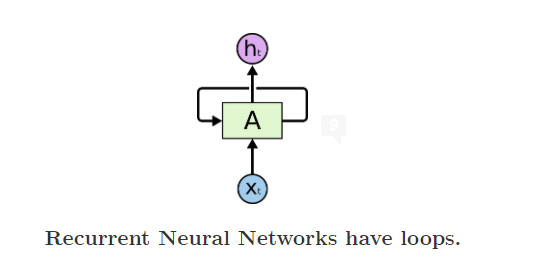

In the above diagram, a chunk of neural network, A, looks at some input xt and outputs a value ht. A loop allows information to be passed from one step of the network to the next.

These loops make recurrent neural networks seem kind of mysterious. However, if you think a bit more, it turns out that they aren’t all that different than a normal neural network. A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor. Consider what happens if we unroll the loop:

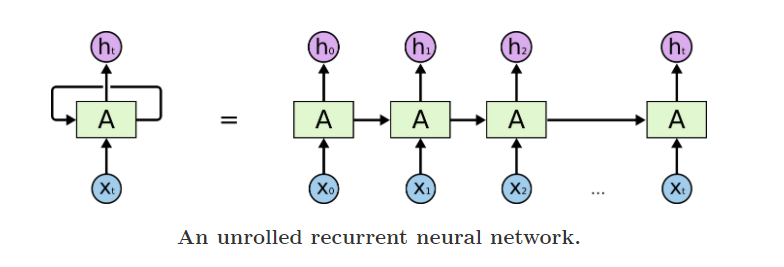

This chain-like nature reveals that recurrent neural networks are intimately related to sequences and lists. They’re the natural architecture of neural network to use for such data.

And they certainly are used! In the last few years, there have been incredible success applying RNNs to a variety of problems: speech recognition, language modeling, translation, image captioning… The list goes on.

Essential to these successes is the use of “LSTMs,” a very special kind of recurrent neural network which works, for many tasks, much much better than the standard version. Almost all exciting results based on recurrent neural networks are achieved with them. It’s these LSTMs that this essay will explore.

**The Problem of Long-Term Dependencies**

One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task, such as using previous video frames might inform the understanding of the present frame. If RNNs could do this, they’d be extremely useful. But can they? It depends.

Sometimes, we only need to look at recent information to perform the present task. For example, consider a language model trying to predict the next word based on the previous ones. If we are trying to predict the last word in “the clouds are in the sky,” we don’t need any further context – it’s pretty obvious the next word is going to be sky. In such cases, where the gap between the relevant information and the place that it’s needed is small, RNNs can learn to use the past information.

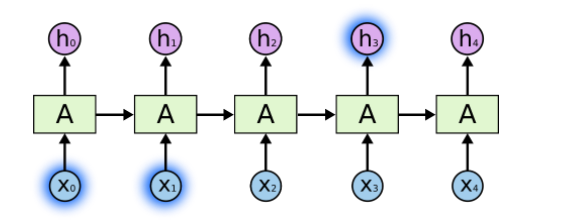

But there are also cases where we need more context. Consider trying to predict the last word in the text “I grew up in France… I speak fluent French.” Recent information suggests that the next word is probably the name of a language, but if we want to narrow down which language, we need the context of France, from further back. It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large.

Unfortunately, as that gap grows, RNNs become unable to learn to connect the information.

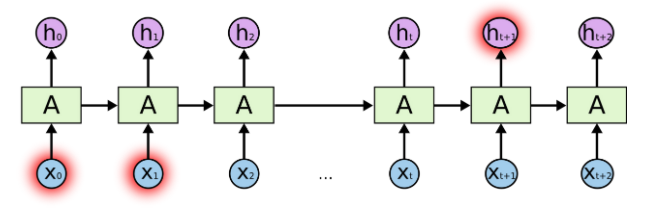

In theory, RNNs are absolutely capable of handling such “long-term dependencies.” A human could carefully pick parameters for them to solve toy problems of this form. Sadly, in practice, RNNs don’t seem to be able to learn them

Thankfully, LSTMs don’t have this problem!

#Basic RNNs

##Generate the Dataset

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl


In [1]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [24]:
series.shape

(10000, 51, 1)

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

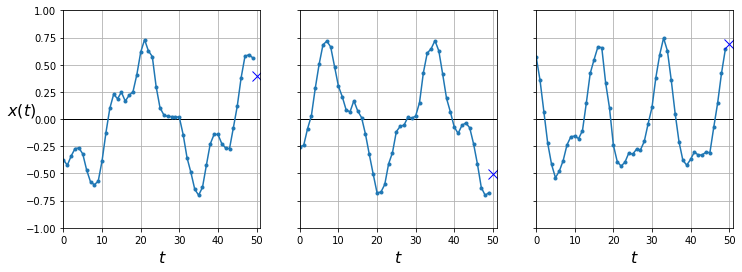

In [10]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

**Computing Some Baselines**


1. Naive predictions (just predict the last observed value):

In [13]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [30]:
X_valid.shape

(2000, 50, 1)

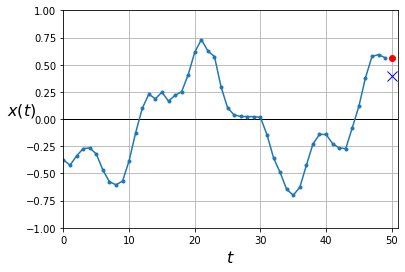

In [14]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

2. Linear predictions:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0062

#LSTM Networks

In [32]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 941us/step - loss: 0.0042


0.004168086685240269

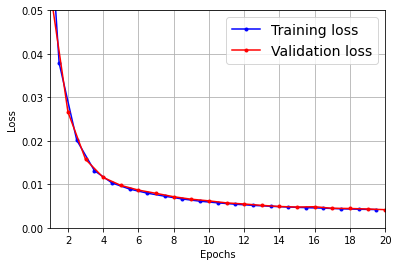

In [36]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

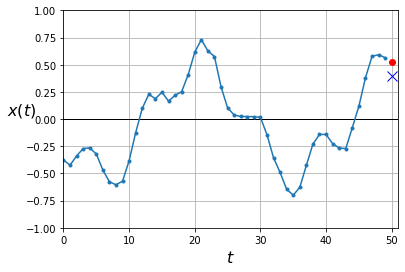

In [34]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

http://colah.github.io/posts/2015-08-Understanding-LSTMs/